              precision    recall  f1-score   support

           0       0.95      0.90      0.93        42
           1       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

EagerPatterns Rule List:
[Class 0]
 - IF mean radius > 11.780000 AND mean concave points > 0.050100 AND worst texture > 20.225000 AND worst perimeter > 105.150000 AND worst perimeter > 112.800000 THEN class=0 (conf=1.00, supp=0.29)
 - IF mean radius > 11.780000 AND mean concavity > 0.089515 AND mean concave points > 0.050100 AND worst perimeter > 105.150000 AND worst perimeter > 112.800000 THEN class=0 (conf=1.00, supp=0.29)
 - IF mean radius > 11.780000 AND mean concavity > 0.089515 AND area error > 31.245000 AND worst texture > 20.225000 AND worst perimeter > 105.150000 THEN class=0 (conf=1.00, supp=0.28)
 - IF mean concavity > 0.089515 AND mean concave points > 

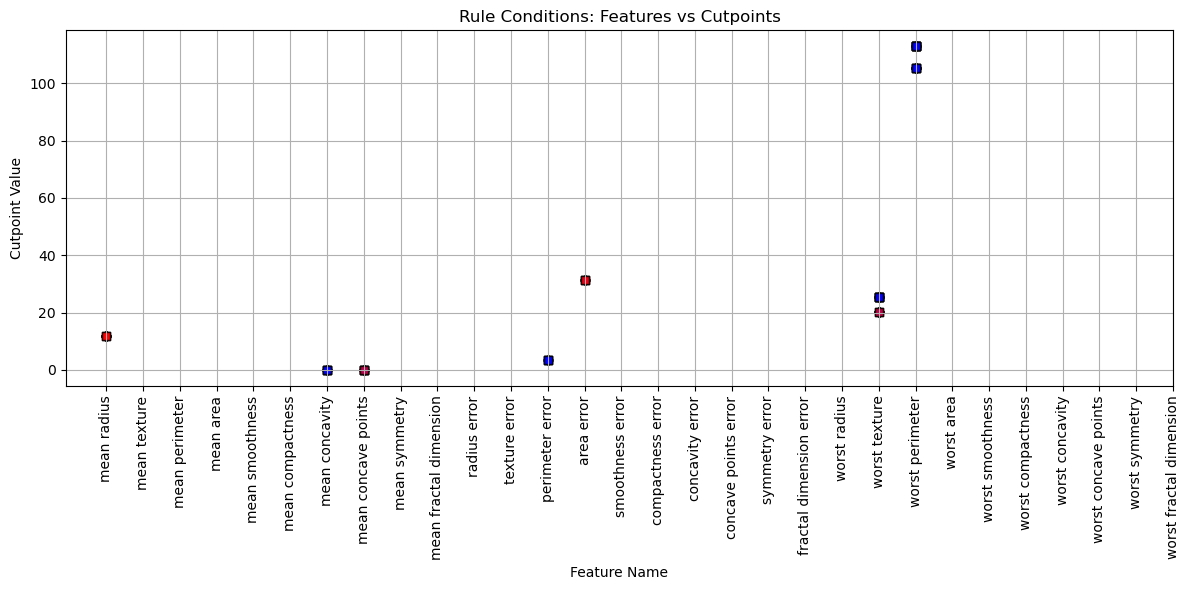

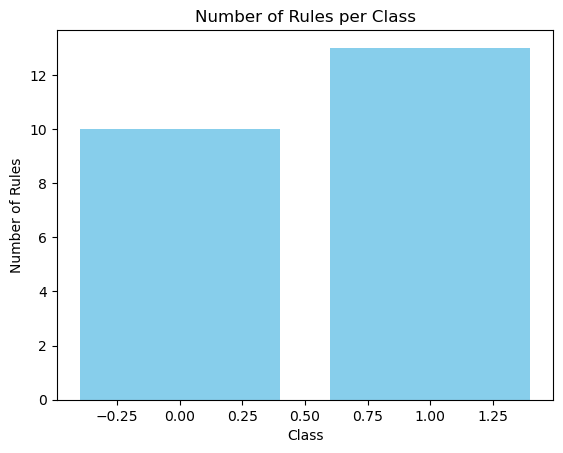

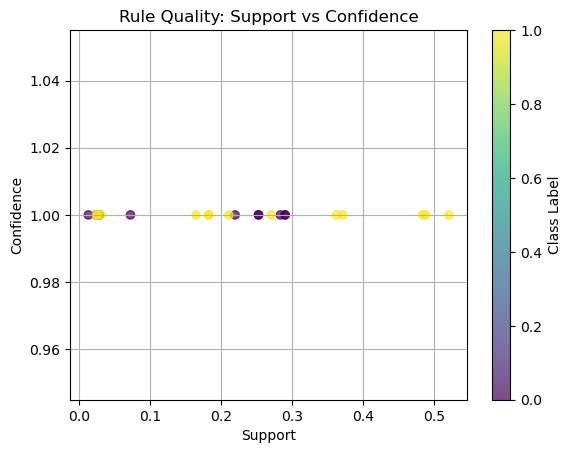

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_validate


class CutpointBinarizer():

    def __init__(self, tolerance=0.0):
        self.__tolerance = tolerance
        self.__cutpoints = {}
        self.__size = 0

    def get_cutpoints(self):
        return self.__cutpoints

    def fit(self, X, y):
        self.__cutpoints.clear()

        att = -1
        for row in X.T:
            att += 1
            labels = None  # Previuos labels
            u = None  # 초기값 변경
            for v in sorted(np.unique(row)):
                if u is None:
                    u = v
                    labels = set(y[np.where(row == v)[0]])
                    continue

                variation = v - u
                indexes = np.where(row == v)[0]
                __labels = set(y[indexes])

                if labels is not None and variation > self.__tolerance:
                    if (len(labels) > 1 or len(__labels) > 1) or labels != __labels:
                        cid = len(self.__cutpoints)
                        self.__cutpoints[cid] = (att, u + variation / 2.0)

                labels = __labels
                u = v

        return self.__cutpoints

    def transform(self, X):
        Xbin = np.empty((X.shape[0], 0), bool)

        for att, cutpoint in self.__cutpoints.values():
            # Binarizing
            if att >= X.shape[1]:
                continue
            row = X[:, att]
            row = row.reshape(X.shape[0], 1) <= cutpoint
            Xbin = np.hstack((Xbin, row))

        return Xbin

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

    def get_cutpoint_order(self):
        return list(self.__cutpoints.keys())
    
class UnWeightedSetCoveringProblem():

    ''' Set covering problem builder '''

    def __init__(self):
        self.__scp = []

    def fit(self, Xbin, y):
        self.__scp.clear()
        labels = np.unique(y)

        for i in range(len(labels)):
            for j in range(i + 1, len(labels)):

                # Crossover
                for u in Xbin[y == labels[i]]:
                    for v in Xbin[y == labels[j]]:
                        self.__scp.append(np.bitwise_xor(u, v))

        self.__scp = np.array(self.__scp)

        return self.__scp


class GreedySetCover():
    
    ''' Set covering problem solver '''
    
    def __init__(self):
        self.__selected = []
        self.__scp = None
        
    def get_selected(self):
        return np.array(self.__selected)
        
    def fit(self, Xbin, y):        
        self.__selected.clear()
        
        builder = UnWeightedSetCoveringProblem()
        scp = builder.fit(Xbin, y)
        
        # print('SCP', scp.shape)
                      
        while len(scp):
            sum_ = scp.sum(axis=0)
            att = np.argmax(sum_)
            
            if sum_[att] == 0: break

            scp = np.delete(scp, np.where(scp[:, att]), axis=0)
            self.__selected.append(att)
            
        self.__selected.sort()
            
    def transform(self, Xbin):
        valid_selected = [att for att in self.__selected if att < Xbin.shape[1]]
        return Xbin[:, valid_selected]
    
    def fit_transform(self, Xbin, y):
        self.fit(Xbin, y)
        return self.transform(Xbin)
    
class LazyPatterns():

    def __init__(self, binarizer, selector):
        self.__Xbin = None
        self.__y = None
        self.__rules = []

        self.__binarizer = binarizer
        self.__selector = selector

    def predict(self, X):
        Xbin = self.__selector.transform(self.__binarizer.transform(X))
        predictions = []

        for instance in Xbin:
            scores = []

            for l in self.__labels:
                attributes = list(np.arange(instance.shape[0]))

                # Stats
                label, confidence, support, lift = self.__get_stats(
                    instance, attributes, l)

                # Choosing rule's attributes
                while len(attributes) > 1:
                    best = None
                    __attributes = attributes.copy()

                    # Find the best attribute to be removed
                    for att in attributes:
                        # Candidate
                        __attributes.remove(att)

                        # Stats
                        _, __confidence, __support, __lift = self.__get_stats(
                            instance, __attributes, l)

                        # Testing candidate
                        if __confidence > confidence \
                            or (__confidence == confidence and __support > support) \
                            or (__confidence == confidence and __support == support and __lift > lift):
                            best = att
                            confidence = __confidence
                            support = __support
                            lift = __lift

                        #
                        __attributes.append(att)

                    if best is None:
                        break

                    # Update rule
                    attributes.remove(best)

                    # Stats
                    label, confidence, support, lift = self.__get_stats(
                        instance, attributes, l)

                # Saving score
                scores.append((label, confidence, support, lift))

            # Best score
            label = sorted(scores, key=lambda x: (x[1], x[2], x[3]))[-1][0]
            predictions.append(label)

            # Forming rule object
            r = {
                'label': label,
                'attributes': attributes.copy(),
                'conditions': list(instance[attributes]),
                'confidence': confidence,
                'support': support,
                'lift': lift
            }

            # Storing rule
            if r not in self.__rules:
                self.__rules.append(r)

        self.__adjust()        
        
        return np.array(predictions)

    def __adjust(self):
        for r in self.__rules:
            conditions = {}
            cutpoints = [self.__binarizer.get_cutpoints()[i] for i in self.__selector.get_selected()[r['attributes']]]

            for i, (att, value) in enumerate(cutpoints):
                condition = conditions.get(att, {})
                symbol = r['conditions'][i]  # True: <=, False: >

                if symbol: condition[symbol] = min(value, condition.get(symbol, value))
                else: condition[symbol] = max(value, condition.get(symbol, value))

                conditions[att] = condition

            r['attributes'].clear()
            r['conditions'].clear()
            r['values'] = []
            
            for att in conditions:
                for condition in conditions[att]:
                    r['attributes'].append(att)
                    r['conditions'].append(condition)
                    r['values'].append(conditions[att][condition])

        self.__rules.sort(key=lambda x: x['label'])
    
    def predict_proba(self, X):
        predictions = self.predict(X)
        output = np.zeros((len(X), len(np.unique(self.__y))))

        for i in range(len(X)):
            output[i][predictions[i]] = 1

        return output

    def fit(self, Xbin, y):
        self.__Xbin = Xbin
        self.__y = y

        unique, counts = np.unique(y, return_counts=True) 
        self.__labels = list(unique)

    def __get_stats(self, instance, attributes, label):
        covered = np.where(
            (self.__Xbin[:, attributes] == instance[attributes]).all(axis=1))

        confidence = 0
        support = 0
        lift = 2

        if len(covered[0]) > 0:
            unique, counts = np.unique(self.__y[covered], return_counts=True)
            argmax = np.argmax(counts)

            if label is None:
                label = unique[argmax]

            if label in unique:
                label_index = np.where(unique == label)[0][0]
                confidence = counts[label_index] / sum(counts)
                support = counts[label_index] / self.__Xbin.shape[0]
                lift = confidence / (np.mean(self.__y == label) + 1e-6)

        return label, confidence, support, lift

    def __str__(self):
        s = f'LazyPatterns Set of Rules:\n'
        
        for r in self.__rules:
            label = r['label']
            # weight = r['weight']
            conditions = []

            for i, condition in enumerate(r['conditions']):
                att = r['attributes'][i]
                val = r['values'][i]

                if (condition):
                    conditions.append(f'att{att} <= {val:.4}')
                else:
                    conditions.append(f'att{att} > {val:.4}')

            # Label -> CONDITION_1 AND CONDITION_2 AND CONDITION_n
            s += f'{label} \u2192 {" AND ".join(conditions)}\n'

        return s

class MiniCORELS:
    def __init__(self, max_rule_len=3, min_support=0.05, min_confidence=0.8):
        self.max_rule_len = max_rule_len
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.rules = []
        self.default_class = 0

    def fit(self, Xbin, y):
        from itertools import combinations

        n_samples, n_features = Xbin.shape
        self.default_class = np.bincount(y).argmax()

        rules = []
        for size in range(1, self.max_rule_len + 1):
            for attrs in combinations(range(n_features), size):
                mask = np.all(Xbin[:, list(attrs)] == 1, axis=1)
                support = np.mean(mask)
                if support < self.min_support:
                    continue
                if np.any(mask):
                    majority = np.bincount(y[mask]).argmax()
                    confidence = np.mean(y[mask] == majority)
                    if confidence >= self.min_confidence:
                        rules.append((attrs, majority, confidence, support))

        # sort by confidence and support
        self.rules = sorted(rules, key=lambda x: (x[2], x[3]), reverse=True)

    def predict(self, Xbin):
        predictions = []
        for row in Xbin:
            predicted = self.default_class
            for attrs, label, _, _ in self.rules:
                if np.all(row[list(attrs)] == 1):
                    predicted = label
                    break
            predictions.append(predicted)
        return np.array(predictions)

    def predict_proba(self, Xbin):
        preds = self.predict(Xbin)
        n_classes = len(set(preds))
        proba = np.zeros((len(preds), n_classes))
        for i, p in enumerate(preds):
            proba[i][p] = 1
        return proba

    def __str__(self):
        s = 'MiniCORELS Rule List:\n'
        for attrs, label, conf, sup in self.rules:
            conds = [f"att{a}=1" for a in attrs]
            s += f"IF {' AND '.join(conds)} THEN class={label} (conf={conf:.2f}, supp={sup:.2f})\n"
        s += f"ELSE class={self.default_class}\n"
        return s


class EagerPatterns:
    def __init__(self, binarizer, selector, min_conf=0.7, min_supp=0.01):
        self.__rules = []
        self.__binarizer = binarizer
        self.__selector = selector
        self.__min_conf = min_conf
        self.__min_supp = min_supp
        self.__labels = []
        self.__cutpoints = {}

    def fit(self, Xbin, y):
        self.__labels = np.unique(y)
        self.__Xbin = Xbin
        self.__y = y
        self.__cutpoints = self.__binarizer.get_cutpoints()
        selected = self.__selector.get_selected()

        for l in self.__labels:
            class_mask = (y == l)
            for instance in Xbin[class_mask]:
                attributes = list(np.arange(instance.shape[0]))
                label, confidence, support, lift = self.__get_stats(instance, attributes, l)

                while len(attributes) > 1:
                    best = None
                    __attributes = attributes.copy()
                    for att in attributes:
                        __attributes.remove(att)
                        _, c, s, lf = self.__get_stats(instance, __attributes, l)
                        if c > confidence or (c == confidence and s > support):
                            best = att
                            confidence, support, lift = c, s, lf
                        __attributes.append(att)
                    if best is None:
                        break
                    attributes.remove(best)
                    label, confidence, support, lift = self.__get_stats(instance, attributes, l)

                if confidence >= self.__min_conf and support >= self.__min_supp:
                    rule = {
                        'label': label,
                        'attributes': [],
                        'conditions': [],
                        'values': [],
                        'confidence': confidence,
                        'support': support,
                        'lift': lift
                    }
                    # Create a flat list of cutpoints aligned with selector
                    cutpoint_order = self.__binarizer.get_cutpoint_order()
                    selected_cutpoints = [self.__cutpoints[cutpoint_order[i]] for i in selected]

                    for a in attributes:
                        att, cut = selected_cutpoints[a]
                        rule['attributes'].append(att)
                        rule['conditions'].append(bool(instance[a]))
                        rule['values'].append(cut)
                    if rule not in self.__rules:
                        self.__rules.append(rule)

        self.__rules.sort(key=lambda r: (r['label'], -r['confidence'], -r['support']))

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            scores = {l: 0 for l in self.__labels}
            for r in self.__rules:
                match = True
                for att, cond, val in zip(r['attributes'], r['conditions'], r['values']):
                    if cond and not (X[i][att] <= val):
                        match = False
                        break
                    elif not cond and not (X[i][att] > val):
                        match = False
                        break
                if match:
                    scores[r['label']] += r['confidence'] * r['support']
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
        return np.array(predictions)

    def predict_proba(self, X):
        preds = self.predict(X)
        n_classes = len(self.__labels)
        proba = np.zeros((len(preds), n_classes))
        for i, p in enumerate(preds):
            proba[i][p] = 1
        return proba

    def __get_stats(self, instance, attributes, label):
        covered = np.where((self.__Xbin[:, attributes] == instance[attributes]).all(axis=1))
        confidence = 0
        support = 0
        lift = 1
        if len(covered[0]) > 0:
            unique, counts = np.unique(self.__y[covered], return_counts=True)
            if label in unique:
                idx = np.where(unique == label)[0][0]
                confidence = counts[idx] / sum(counts)
                support = counts[idx] / self.__Xbin.shape[0]
                lift = confidence / (np.mean(self.__y == label) + 1e-6)
        return label, confidence, support, lift

    def __str__(self):
        s = f'EagerPatterns Rule List:\n'
        for r in self.__rules:
            label = r['label']
            conditions = []
            for att, cond, val in zip(r['attributes'], r['conditions'], r['values']):
                if cond:
                    conditions.append(f'att{att} <= {val:.4f}')
                else:
                    conditions.append(f'att{att} > {val:.4f}')
            s += f'{label} → {" AND ".join(conditions)} (conf={r["confidence"]:.2f}, supp={r["support"]:.2f})\n'
        return s
    

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            scores = {l: 0 for l in self.__labels}
            for r in self.__rules:
                match = True
                for att, cond, val in zip(r['attributes'], r['conditions'], r['values']):
                    if cond and not (X[i][att] <= val):
                        match = False
                        break
                    elif not cond and not (X[i][att] > val):
                        match = False
                        break
                if match:
                    scores[r['label']] += r['confidence'] * r['support']
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
        return np.array(predictions)

    def predict_proba(self, X):
        preds = self.predict(X)
        n_classes = len(self.__labels)
        proba = np.zeros((len(preds), n_classes))
        for i, p in enumerate(preds):
            proba[i][p] = 1
        return proba

    def __get_stats(self, instance, attributes, label):
        covered = np.where((self.__Xbin[:, attributes] == instance[attributes]).all(axis=1))
        confidence = 0
        support = 0
        lift = 1
        if len(covered[0]) > 0:
            unique, counts = np.unique(self.__y[covered], return_counts=True)
            argmax = np.argmax(counts)
            if label in unique:
                idx = np.where(unique == label)[0][0]
                confidence = counts[idx] / sum(counts)
                support = counts[idx] / self.__Xbin.shape[0]
                lift = confidence / (np.mean(self.__y == label) + 1e-6)
        return label, confidence, support, lift

    def __str__(self):
        from collections import defaultdict
        grouped = defaultdict(list)
        for r in self.__rules:
            grouped[r['label']].append(r)

        s = 'EagerPatterns Rule List:\n'
        for label in sorted(grouped):
            s += f'[Class {label}]\n'
            for r in grouped[label]:
                conds = []
                for att, cond, val in zip(r['attributes'], r['conditions'], r['values']):
                    name = self.__feature_names[att] if hasattr(self, '_EagerPatterns__feature_names') else f'att{att}'
                    if cond:
                        conds.append(f'{name} <= {val:.6f}')
                    else:
                        conds.append(f'{name} > {val:.6f}')
                s += f' - IF {" AND ".join(conds)} THEN class={label} (conf={r["confidence"]:.2f}, supp={r["support"]:.2f})\n'
        return s

    def __adjust(self):
        unique_rules = {}
        for r in self.__rules:
            # Normalize rule key by sorting and rounding
            key_parts = [
                (r['attributes'][i], r['conditions'][i], round(r['values'][i], 6))
                for i in range(len(r['attributes']))
            ]
            key = tuple(sorted(key_parts))  # Order-invariant key
            if key not in unique_rules or r['confidence'] > unique_rules[key]['confidence']:
                unique_rules[key] = r
        self.__rules = sorted(
            unique_rules.values(),
            key=lambda r: (r['label'], -r['confidence'], -r['support'], -r['lift'])
        )

    # Added method to set feature names
    def set_feature_names(self, feature_names):
        self.__feature_names = feature_names
    
    def save_rules(self, filepath):
        import json
        import numpy as np
        
        def convert(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            if isinstance(obj, np.floating):
                return float(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        with open(filepath, 'w') as f:
            json.dump(self.__rules, f, indent=2, default=convert)
    
class LADClassifier(BaseEstimator, ClassifierMixin):
    '''
        LAD Classifier

        Implements the Maximized Prime Patterns heuristic described in the
        "Maximum Patterns in Datasets" paper. It generates one pattern (rule)
        per observation, while attempting to: (i) maximize the coverage of other
        observations belonging to the same class, and (ii) preventing the
        coverage of too many observations from outside that class. The amount of
        "outside" coverage allowed is controlled by the minimum purity parameter
        (from the main LAD classifier).

        Attributes
        ---------
        tolerance: float
            Tolerance for cutpoint generation. A cutpoint will only be generated 
            between two values if they differ by tat least this value. (Default = 0.0)

        purity: float
            Minimum purity requirement for rules. This is an upper bound on the 
            number of points from any another class that are covered by a rule 
            (as a percentage of the total number of points covered by the rule).
            (Default = 0.95)

        mode: str
            The algorithm mode used for generating classsification rules. Possible
            values: {eager, lazy}
    '''

    def __init__(self, tolerance=0.001, purity=0.95, mode="eager"):
        self.tolerance = tolerance
        self.purity = purity
        self.mode = mode

        self.model = None
        self.cpb = CutpointBinarizer(self.tolerance)
        self.gsc = GreedySetCover()

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=True)
        self.is_fitted_ = True

        # print('# Binarization')
        Xbin = self.cpb.fit_transform(X, y)

        Xbin = self.gsc.fit_transform(Xbin, y)

        # print('# Rule building')
        if self.mode == 'brl':
            from imodels import BayesianRuleListClassifier
            self.model = BayesianRuleListClassifier(
                listlengthprior=3,
                listwidthprior=1,
                alpha=[1.0, 1.0],
                n_chains=5
            )
            self.model.fit(Xbin, y)
        elif self.mode == 'corels':
            self.model = MiniCORELS()
            self.model.fit(Xbin, y)
        elif self.mode == 'eager':
            self.model = EagerPatterns(self.cpb, self.gsc)
            self.model.fit(Xbin, y)
        # self.__adjust()

        return self  # `fit` should always return `self`

    def predict(self, X):
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        if self.mode in ['brl', 'corels']:
            Xbin = self.gsc.transform(self.cpb.transform(X))
            return self.model.predict(Xbin)
        return self.model.predict(X)

    def predict_proba(self, X):
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        if self.mode in ['brl', 'corels']:
            Xbin = self.gsc.transform(self.cpb.transform(X))
            return self.model.predict_proba(Xbin)
        return self.model.predict_proba(X)

    def __str__(self):
        return self.model.__str__()

    def save_model(self, filepath):
        if hasattr(self.model, 'save_rules'):
            self.model.save_rules(filepath)
        else:
            raise NotImplementedError("Saving not supported for this model type.")

    def load_model(self, filepath):
        if hasattr(self.model, 'load_rules'):
            self.model.load_rules(filepath)
        else:
            raise NotImplementedError("Loading not supported for this model type.")

# Load
X, y = datasets.load_breast_cancer(return_X_y=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Clasisfier
clf = LADClassifier(mode='eager')
clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)

print(classification_report(y_test, y_hat))
# print(clf)


# cutpoints = clf.cpb.get_cutpoints()
# for cid, (att, cut) in cutpoints.items():
#     print(f'cutpoint {cid}: att{att} <= {cut:.6f}')
# clf.save_model("eager_rules.json")
feature_names =  datasets.load_breast_cancer().feature_names.tolist()
# feature 이름 지정
clf.model.set_feature_names(feature_names)

# 규칙 출력
print(clf)
import matplotlib.pyplot as plt
import numpy as np

# 규칙 시각화용 데이터 추출
rules = clf.model._EagerPatterns__rules

att_list = []
cut_list = []
label_list = []
sign_list = []

for r in rules:
    for att, cond, val in zip(r['attributes'], r['conditions'], r['values']):
        att_list.append(att)
        cut_list.append(val)
        label_list.append(r['label'])
        sign_list.append(cond)

# 시각화 1: 조건별 scatter plot
plt.figure(figsize=(12, 6))
colors = ['blue' if cond else 'red' for cond in sign_list]
markers = ['o' if label == 0 else 's' for label in label_list]
for x, y, c, m in zip(att_list, cut_list, colors, markers):
    plt.scatter(x, y, color=c, marker=m, edgecolor='k', alpha=0.7)
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Cutpoint Value")
plt.title("Rule Conditions: Features vs Cutpoints")
plt.grid(True)
plt.tight_layout()
plt.show()

# 시각화 2: 클래스별 규칙 수
from collections import Counter
class_counts = Counter(r['label'] for r in rules)
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Rules")
plt.title("Number of Rules per Class")
plt.show()

# 시각화 3: confidence vs support
conf = [r['confidence'] for r in rules]
supp = [r['support'] for r in rules]
colors = [r['label'] for r in rules]
plt.scatter(supp, conf, c=colors, cmap='viridis', alpha=0.7)
plt.colorbar(label='Class Label')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Rule Quality: Support vs Confidence')
plt.grid(True)
plt.show()